# Run 1.1p test

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Loads tract 4849

In [2]:
import h5py 

# This file was generated using the merged_tract_cat.py script with following command line:
# $ python merge_tract_cat.py --verbose /global/projecta/projectdirs/lsst/global/in2p3/Run1.1-test2/output 4849
f = h5py.File('/global/homes/f/flanusse/flanusse/merged_tract_4849.hdf5', 'r')

# Aggregate all the different patches
data = None
for i in f:
    if data is None:
        data = pd.read_hdf('/global/homes/f/flanusse/flanusse/merged_tract_4849.hdf5',i,ignore_index=True)
    else:
        data = data.append(pd.read_hdf('/global/homes/f/flanusse/flanusse/merged_tract_4849.hdf5',i,ignore_index=True))

# Apply basic lensing cuts

In [3]:
#  First remove some nan entrie 
mask = ~(isnan(data['i_modelfit_CModel_flux']) | isnan(data['ext_shapeHSM_HsmShapeRegauss_resolution']) | isnan(data['ext_shapeHSM_HsmShapeRegauss_e1']))
data = data[mask]

In [5]:
# How many objects remain after basic nan cuts
print(len(data))

363688


In [6]:
# Lensing cuts based on Mandelbaum 2017 (arxiv 1705.06745)
# Basic flag cuts
mask = data['detect_isPrimary']
mask &= data['deblend_skipped'] == False
mask &= data['base_PixelFlags_flag_edge'] == False
mask &= data['base_PixelFlags_flag_interpolatedCenter'] == False
mask &= data['base_PixelFlags_flag_saturatedCenter'] == False
mask &= data['base_PixelFlags_flag_crCenter'] == False
mask &= data['base_PixelFlags_flag_bad'] == False
mask &= data['base_PixelFlags_flag_suspectCenter'] == False
mask &= data['base_PixelFlags_flag_clipped'] == False
mask &= data['ext_shapeHSM_HsmShapeRegauss_flag'] == False

# Cut on object properties
mask &= data['i_modelfit_CModel_flux']/data['i_modelfit_CModel_fluxSigma'] >= 10
mask &= data['ext_shapeHSM_HsmShapeRegauss_resolution'] >= 0.3
mask &= sqrt(data['ext_shapeHSM_HsmShapeRegauss_e1']**2 + data['ext_shapeHSM_HsmShapeRegauss_e2']**2) < 2
mask &= data['ext_shapeHSM_HsmShapeRegauss_sigma'] <= 0.4
mask &= (-2.5 * np.log10(data['i_modelfit_CModel_flux']) + 27.) < 24.5 # !!! Doesnt have exinction correction
mask &= data['base_Blendedness_abs_flux']< 10**(-0.375)

/global/common/software/lsst/common/miniconda/py3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/global/common/software/lsst/common/miniconda/py3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in log10


## Plot distribution of galaxy properties

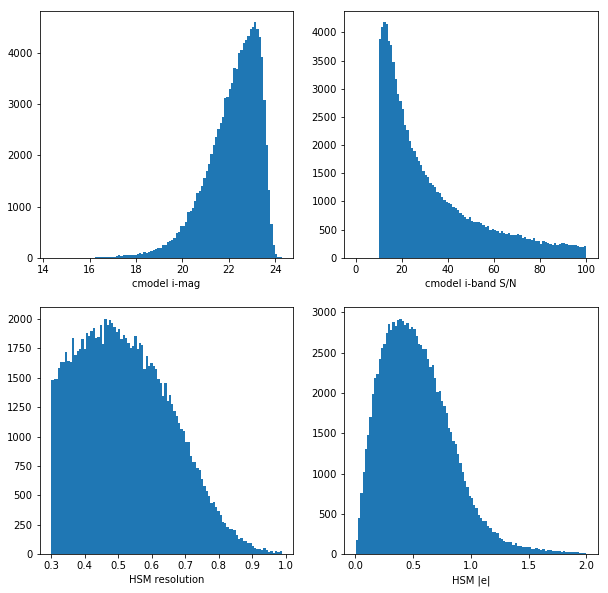

In [7]:
figure(figsize=(10,10))
subplot(221)
hist(-2.5 * np.log10(data['i_modelfit_CModel_flux'][mask]) + 27.,100);
xlabel('cmodel i-mag')
xlim()
subplot(222)
hist(data['i_modelfit_CModel_flux'][mask]/data['i_modelfit_CModel_fluxSigma'][mask],100,range=[0,100])
xlabel('cmodel i-band S/N')
subplot(223)
hist(data['ext_shapeHSM_HsmShapeRegauss_resolution'][mask],100);
xlabel('HSM resolution')
subplot(224)
hist(sqrt(data['ext_shapeHSM_HsmShapeRegauss_e1']**2 + data['ext_shapeHSM_HsmShapeRegauss_e2']**2)[mask],100);
xlabel('HSM |e|')

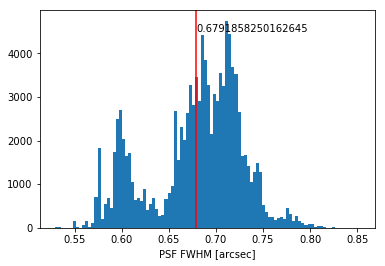

In [10]:
# Computes the PSF FWHM 
psf_size = 0.168 * 2.355 * (data['i_base_SdssShape_psf_xx'] * data['i_base_SdssShape_psf_yy'] - data['i_base_SdssShape_psf_xy']**2)**(0.25)
hist(psf_size[mask],100);
axvline(mean(psf_size[mask]),c='r')
text(mean(psf_size[mask]), 4500, mean(psf_size[mask]) )
xlabel('PSF FWHM [arcsec]')